# Unconstrained Optimality Conditions



In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import sys
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py"

else:
    sys.path.insert(0, '../')

from helper import set_plotting_style
set_plotting_style()


[Handout for Theorems 2.17 and 2.18 from Biegler (2010)](../../handouts/Theorem_proof_activity.pdf)

## Local and Global Solutions

## Necessary Conditions for Optimality

## Sufficient Conditions for Optimality

## Example 2.19 in Biegler (2010)

**Main Idea**: Use the necessary and sufficient conditions to classify a candidate solution.

![Book](https://raw.githubusercontent.com/ndcbe/optimization/main/media/ex2-19.png)

### The Test Function

f(x*) =  -5.089256907976166 



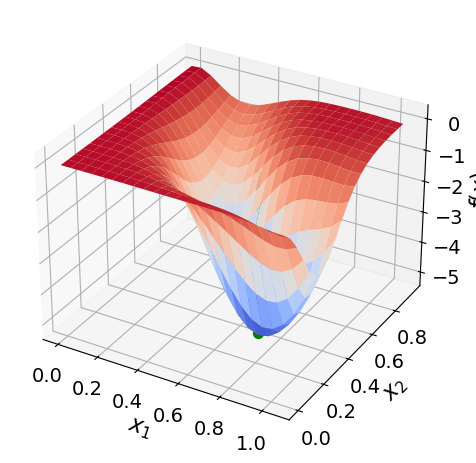

In [2]:
## Define Python function
def my_f(x,verbose=False):
    ''' Evaluate function given above at point x

    Inputs:
        x - vector with 2 elements
        
    Outputs:
        f - function value (scalar)
    '''
    # Constants
    a = np.array([0.3, 0.6, 0.2])
    b = np.array([5, 26, 3])
    c = np.array([40, 1, 10])
    
    # Intermediates. Recall Python indicies start at 0
    u = x[0] - 0.8
    s = np.sqrt(1-u)
    s2 = np.sqrt(1+u)
    v = x[1] -(a[0] + a[1]*u**2*s-a[2]*u)
    alpha = -b[0] + b[1]*u**2*s2+ b[2]*u # September 5, 2018: changed 's' to 's2'
    beta = c[0]*v**2*(1-c[1]*v)/(1+c[2]*u**2)
    f = alpha*np.exp(-beta)
    
    if verbose:
        print("##### my_f at x = ",x, "#####")
        print("u = ",u)
        print("sqrt(1-u) = ",s)
        print("sqrt(1+u) = ",s2)
        print("v = ",v)
        print("alpha = ",alpha)
        print("beta = ",beta)
        print("f(x) = ",f)
        print("##### Done. #####\n")
    
    return f

## Define candidate point and check against value reported in book
xtest = np.array([0.7395, 0.3144])
ftest = my_f(xtest)
print("f(x*) = ",my_f(xtest),"\n")

## Make 3D plot to visualize
x1 = np.arange(0.0,1.1,0.05)
x2 = np.arange(0.0,1.0,0.05)

# Create a matrix of all points to sample
X1, X2 = np.meshgrid(x1, x2)
n1 = len(x1)
n2 = len(x2)

# Notice the order. This was wrong in quadratic.ipynb and has been corrected in quadratic_update.ipynb
F = np.zeros([n2, n1])

xtemp = np.zeros(2)

# Evaluate f(x) over grid
for i in range(0,n1):
    xtemp[0] = x1[i]
    for j in range(0,n2):
        xtemp[1] = x2[j]
        F[j,i] = my_f(xtemp)

# Create 3D figure
ax = plt.figure().add_subplot(projection='3d')

# Plot f(x)
surf = ax.plot_surface(X1, X2, F, linewidth=0,cmap=cm.coolwarm,antialiased=True)

# Add candidate point
ax.scatter(xtest[0],xtest[1],ftest,s=50,color="green",depthshade=True)

# Draw vertical line through stationary point to help visualization
# Maximum value in array
fmax = np.amax(F)
fmin = np.amin(F)
ax.plot([xtest[0], xtest[0]], [xtest[1], xtest[1]], [fmin,fmax],color="green")

ax.set_xlabel('$x_{1}$')
ax.set_ylabel('$x_{2}$')
ax.set_zlabel('$f(x)$')

plt.tight_layout()
plt.show()

**Discussion**: Based on the 3D plot, is this function convex?

### Finite Difference Gradient and Hessian

We need the calculate $\nabla f(x)$ and $\nabla^2 f(x)$ to analyze a given point. Below are functions that implement a central finite difference. Another option it to analytical calculate the derivatives or use automatic differentiation.

In [3]:
## Gradient
def my_grad(x,verbose=True):
    '''
    Calculate gradient of function my_f using central difference formula
    
    Inputs:
        x - point for which to evaluate gradient
        
    Outputs:
        grad - gradient (vector)
        
    Assumptions:
        1. my_f is defined
        2. input x has the correct number of elements for my_f
        3. my_f is continous and differentiable    
    '''
    
    eps = 1E-6
    n = len(x)
    grad = np.zeros(n)

    if(verbose):
        print("***** my_grad at x = ",x,"*****")
    
    for i in range(0,n):
        
        # Create vector of zeros except eps in position i
        e = np.zeros(n)
        e[i] = eps
        
        # Finite difference formula
        my_f_plus = my_f(x + e)
        my_f_minus = my_f(x - e)
        
        # Diagnostics
        if(verbose):
            print("e[",i,"] = ",e)
            print("f(x + e[",i,"]) = ",my_f_plus)
            print("f(x - e[",i,"]) = ",my_f_minus)
        
        
        grad[i] = (my_f_plus - my_f_minus)/(2*eps)
    
    if(verbose):
        print("***** Done. ***** \n")
    
    return grad

grad = my_grad(xtest)
print(grad)

***** my_grad at x =  [0.7395 0.3144] *****
e[ 0 ] =  [1.e-06 0.e+00]
f(x + e[ 0 ]) =  -5.089256904035737
f(x - e[ 0 ]) =  -5.089256911839596
e[ 1 ] =  [0.e+00 1.e-06]
f(x + e[ 1 ]) =  -5.089256892701673
f(x - e[ 1 ]) =  -5.089256922857939
***** Done. ***** 

[0.00390193 0.01507813]


**Discussion**: According to the book, $\nabla f(x_{test}) = 0$. Is the above answer reasonable?

**Note**: Before fixing the mistake in `my_f`, the gradient was `[-0.28182046  0.01506107]`. The version we discussed in class had the mistake in `my_f`.

In [4]:
## Hessian
def my_hes(x):
    '''
    Calculate gradient of function my_f using central difference formula and my_grad
    
    Inputs:
        x - point for which to evaluate gradient
        
    Outputs:
        H - Hessian (matrix)
        
    Assumptions:
        1. my_f and my_grad is defined
        2. input x has the correct number of elements for my_f
        3. my_f is continous and twice differentiable
        4. No mistakes in my_grad
    '''
    
    eps = 1E-6
    n = len(x)
    H = np.zeros([n,n])
    
    for i in range(0,n):
        # Create vector of zeros except eps in position i
        e = np.zeros(n)
        e[i] = eps
        
        # Evaluate gradient twice
        grad_plus = my_grad(x + e,verbose=False)
        grad_minus = my_grad(x - e,verbose=False)
        
        # Notice we are building the Hessian by column (or row)
        H[:,i] = (grad_plus - grad_minus)/(2*eps)
    
    '''
    Note: This is not very efficient. You can probably this of several 
    performance improvements. We will learn more practical ways to approximate 
    the Hessian for optimization algorithms in the next few lectures.
    '''
    
    return H

H = my_hes(xtest)
print(H)

[[ 76.99973992 108.3413359 ]
 [108.3413359  392.7191905 ]]


**Primary Discussion**: How does this compare to the answer given in the book? Which elements are very close to the given answer? Which have greater error? Why does this make sense?

**Secondary Discussion**: What happens if you set `eps` to different values in `my_grad` and `my_hes`? Is `H` still symmetric?

### Analysis of Optimality Conditions

**Activity**
1. Calculate the eigenvalues of H.
2. Is $x_{test}$ a
    * stationary point
    * local maximizer
    * strict global maximizer
    * global maximizer
    * local minimizer
    * strict local minimizer
    * global minimizer
    
Answer Yes, No, or Possibly for each bullet point.

In [5]:
# Add your solution here

[ 43.39788177+0.j 426.32104865+0.j]


## Continuous Optimization Algorithms

* Gradient-based Algorithms
   * Conjugate gradient methods
   * Sequential quadratic programming methods
   * Sequential linear programming methods
   * Interior point methods
* Derivative-free optimization
   * Deterministic algorithms
      * Nelder–Mead method
   * Stochastic algorithms
       * Simulated Annealing
       * Genetic Algorithms